In [39]:
'''
!pip install -U transformers
!pip install -U acceerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
'''

'\n!pip install -U transformers\n!pip install -U acceerate\n!pip install -U datasets\n!pip install -U bertviz\n!pip install -U umap-learn\n'

In [40]:
import numpy as np
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import FileLink
import re
import warnings
warnings.filterwarnings('ignore')

In [41]:
# Importing the dataset
df_train = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin')
df_test = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin')

# Checking columns in the dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


**Data Preprocessing**

In [42]:
df_train.drop_duplicates(subset='OriginalTweet',inplace=True)

In [43]:
df_train = df_train[['OriginalTweet', 'Sentiment']].rename(columns={'OriginalTweet': 'tweets', 'Sentiment': 'sentiment'})
df_test = df_test[['OriginalTweet', 'Sentiment']].rename(columns={'OriginalTweet': 'tweets', 'Sentiment': 'sentiment'})
label_mapping = {
    'Extremely Positive':4,
    'Positive': 3,
    'Neutral': 2,
    'Negative': 1,
    'Extremely Negative':0

}
df_train['label']=df_train.sentiment.map(label_mapping)
df_train.head()

tweets           sentiment  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral   
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   

   label  
0      2  
1      3  
2      3  
3      3  
4      0

In [44]:
print("Null values in the train dataset:")
display(df_train.isna().mean())
print("Null values in the test dataset:")
display(df_test.isna().mean())

Null values in the train dataset:


tweets       0.0
sentiment    0.0
label        0.0
dtype: float64

Null values in the test dataset:


tweets       0.0
sentiment    0.0
dtype: float64

# Plotting the distribution of sentiment labels 

<Axes: ylabel='sentiment'>

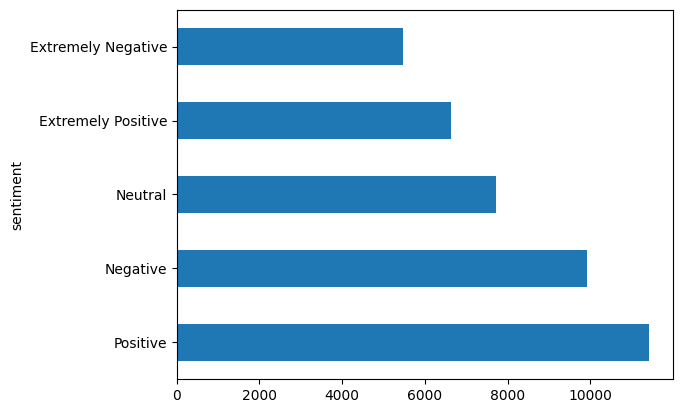

In [45]:
df_train.sentiment.value_counts().plot(kind='barh')

In [46]:
def convert_to_lower(text):
    return text.lower()


def remove_emojis(text):
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r"<.*?>","",text)
    
    
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    
    return wierd_pattern.sub(r'', text)


def remove_punctuation(text):
    # Remove punctuation and carriage return/newline characters
    cleaned_text = re.sub(r'[^\w\s]+|[\r\n]', '', text)
    return cleaned_text


def remove_extra_white_spaces(text):
    clean_text=text.strip()
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=clean_text)
    return without_sc


def preprocessText(text):
  return remove_extra_white_spaces(remove_punctuation(remove_emojis(convert_to_lower(text))))



df_train['tweets'] = df_train['tweets'].apply(preprocessText)
df_test['tweets'] = df_test['tweets'].apply(preprocessText)

Check the lenght of the cleaned text

In [47]:
def check_len(df):
    text_len=[]
    for text in df.tweets:
        tweet_len=len(text.split())
        text_len.append(tweet_len)
    return text_len

In [48]:
df_train['text_len'] = check_len(df_train)

# another way
df_train['Words per tweet']=df_train['tweets'].str.split().apply(len)

In [49]:
df_train.drop('text_len',axis=1,inplace=True)

(array([1, 2, 3, 4, 5]),
 [Text(1, 0, 'Extremely Negative'),
  Text(2, 0, 'Extremely Positive'),
  Text(3, 0, 'Negative'),
  Text(4, 0, 'Neutral'),
  Text(5, 0, 'Positive')])

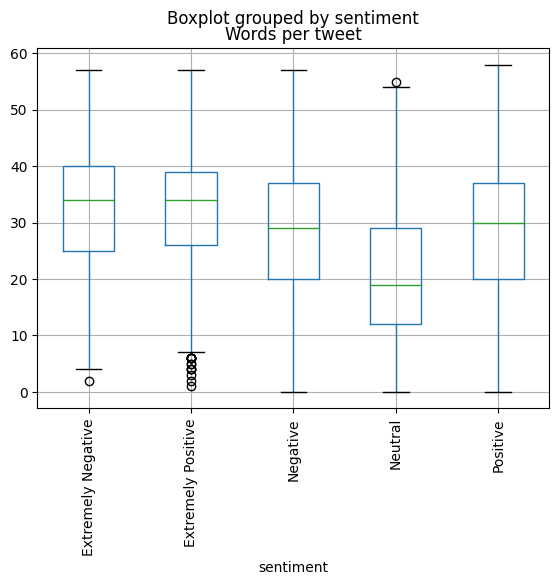

In [50]:

df_train.boxplot('Words per tweet',by='sentiment')
plt.xticks(rotation=90)

In [51]:
'''
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_train[df_train['text_len']>20], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
plt.xticks(rotation=90)
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()
'''

"\nplt.figure(figsize=(7,5))\nax = sns.countplot(x='text_len', data=df_train[df_train['text_len']>20], palette='mako')\nplt.title('Training tweets with less than 10 words')\nplt.yticks([])\nplt.xticks(rotation=90)\nax.bar_label(ax.containers[0])\nplt.ylabel('count')\nplt.xlabel('')\nplt.show()\n"

Drop tweets that have 0 words.

In [52]:
from transformers import AutoTokenizer
model_ckpt='bert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [53]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df_train,test_size=0.3,stratify=df_train.sentiment)
test, val=train_test_split(test,test_size=1/3,stratify=test.sentiment)

In [54]:
train.shape,test.shape,val.shape

((28809, 4), (8232, 4), (4116, 4))

In [55]:
#!pip install datasets

In [56]:
from datasets import Dataset, DatasetDict
dataset=DatasetDict(
    {'train':Dataset.from_pandas(train,preserve_index=False),
     'test':Dataset.from_pandas(test,preserve_index=False),
     'validation':Dataset.from_pandas(val,preserve_index=False)
     }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['tweets', 'sentiment', 'label', 'Words per tweet'],
        num_rows: 28809
    })
    test: Dataset({
        features: ['tweets', 'sentiment', 'label', 'Words per tweet'],
        num_rows: 8232
    })
    validation: Dataset({
        features: ['tweets', 'sentiment', 'label', 'Words per tweet'],
        num_rows: 4116
    })
})

In [57]:
dataset['train'][0],dataset['train'][1]

({'tweets': 'european electricity demand shrinks due to the coronavirus crisis which also causes falls in prices in the electricitymarkets brentoil ttf and co2 covid_19',
  'sentiment': 'Extremely Negative',
  'label': 0,
  'Words per tweet': 23},
 {'tweets': 'to the shops hiking up prices shame on you dont mean people cashing in on ebay etc mean actual local shops increasing prices of meat rice etci thought we were all trying to get through this together ridiculous  coronavirus',
  'sentiment': 'Extremely Negative',
  'label': 0,
  'Words per tweet': 39})

In [58]:
def tokenize(batch):
  temp=tokenizer(batch['tweets'],padding=True,truncation=True,max_length=512)
  return temp
print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 2647, 6451, 5157, 22802, 2015, 2349, 2000, 1996, 21887, 23350, 5325, 2029, 2036, 5320, 4212, 1999, 7597, 1999, 1996, 6451, 20285, 2015, 12895, 10448, 2140, 23746, 2546, 1998, 2522, 2475, 2522, 17258, 1035, 2539, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2000, 1996, 7340, 13039, 2039, 7597, 9467, 2006, 2017, 2123, 2102, 2812, 2111, 5356, 2075, 1999, 2006, 1041, 15907, 4385, 2812, 5025, 2334, 7340, 4852, 7597, 1997, 6240, 5785, 4385, 2072, 2245, 2057, 2020, 2035, 2667, 2000, 2131, 2083, 2023, 2362, 9951, 21887, 23350, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0

In [59]:
sentiment_encoded=dataset.map(tokenize,batched=True, batch_size=None)

Map:   0%|          | 0/28809 [00:00<?, ? examples/s]

Map:   0%|          | 0/8232 [00:00<?, ? examples/s]

Map:   0%|          | 0/4116 [00:00<?, ? examples/s]

In [60]:
label2id={x['sentiment']:x['label'] for x in dataset['train']}
id2label={v:k for k, v in label2id.items()}
label2id, id2label

({'Extremely Negative': 0,
  'Neutral': 2,
  'Positive': 3,
  'Negative': 1,
  'Extremely Positive': 4},
 {0: 'Extremely Negative',
  2: 'Neutral',
  3: 'Positive',
  1: 'Negative',
  4: 'Extremely Positive'})

In [61]:
from transformers import AutoModel
model=AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [62]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

num_labels=len(label2id)
device=torch.device('cuda' if torch.cuda.is_available() else'cpu')
config=AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model=AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Extremely Negative",
    "1": "Negative",
    "2": "Neutral",
    "3": "Positive",
    "4": "Extremely Positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Extremely Negative": 0,
    "Extremely Positive": 4,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.45.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [64]:
from transformers import TrainingArguments

batch_size=64
training_dir='bert_base_train_dir'
training_args=TrainingArguments(output_dir=training_dir,
                                overwrite_output_dir=True,
                                num_train_epochs=3,
                                learning_rate=2e-5,
                                per_device_train_batch_size=batch_size,
                                per_device_eval_batch_size=batch_size,
                                evaluation_strategy='epoch',
                                disable_tqdm=False
                                )

In [65]:
from sklearn.metrics import accuracy_score,f1_score
def compute_metrics(pred):
  labels=pred.label_ids
  preds=pred.predictions.argmax(-1)
  f1=f1_score(labels,preds,average='weighted')
  acc=accuracy_score(labels,preds)
  return {'accuracy':acc,'f1':f1}

In [66]:
from transformers import Trainer
trainer=Trainer(model=model,
                args=training_args,
                compute_metrics=compute_metrics,
                train_dataset=sentiment_encoded['train'],
                eval_dataset=sentiment_encoded['validation'],
                tokenizer=tokenizer)

In [67]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


TrainOutput(global_step=678, training_loss=0.8446618251744273, metrics={'train_runtime': 1068.2935, 'train_samples_per_second': 80.902, 'train_steps_per_second': 0.635, 'total_flos': 4619166438805776.0, 'train_loss': 0.8446618251744273, 'epoch': 3.0})

In [79]:
preds_output=trainer.predict(sentiment_encoded['test'])

In [69]:
y_pred=np.argmax(preds_output.predictions,axis=1)

In [70]:
y_true=sentiment_encoded['test']['label']

Text(0.5, 25.722222222222214, 'Predicted')

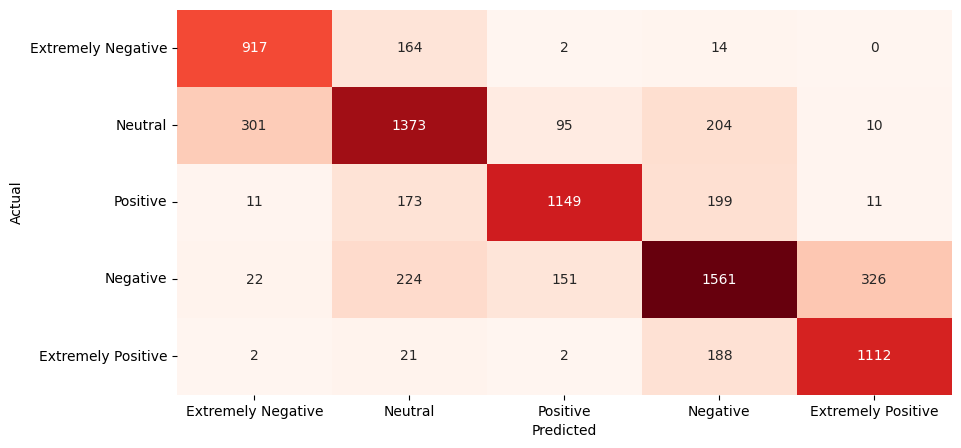

In [71]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,5))
sns.heatmap(cm,annot=True,xticklabels=label2id.keys(),yticklabels=label2id.keys(),fmt='d',cbar=False,cmap='Reds')
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [73]:
text='Covid is dangerous'

def make_pred(text):

  input_encoded=tokenizer(text,return_tensors='pt').to(device)
  with torch.no_grad():
    outputs=model(**input_encoded)

  logits=outputs.logits

  pred=torch.argmax(logits,dim=1).item()
  return pred, id2label[pred]
make_pred(text)

(1, 'Negative')

In [80]:
trainer.save_model('bert-base-uncase-sentiment-model')

In [91]:
# create pipeline for prediction
from transformers import pipeline
classifier=pipeline('text-classification',model='bert-base-uncase-sentiment-model')
classifier(text)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'Negative', 'score': 0.6915785670280457}]

In [85]:
pip install streamlit -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [94]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
from transformers import pipeline

st.title('Fine Tuning BERT for Multi Class Sentiment Classification')
classifier=pipeline('text-classification',model='bert-base-uncase-sentiment-model')

text=st.text_area('Enter text')

if st.button('Predict'):
    result=classifier(text) 
    st.write(result)

Overwriting app.py


In [83]:
!npm install -g localtunnel@2.0.2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


m#################.] - reify:debug: http fetch GET 200 https://registry.npmjs.o
added 22 packages in 2s

3 packages are looking for funding
  run `npm fund` for details


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.19.2.2:8501
  External URL: http://34.71.69.67:8501

your url is: https://lemon-pants-dress.loca.lt
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Hardware accelerator e.g. GPU is available in the 